# Bimodal Churn Prediction: Integrating Structured Data and LLM-Based Text Embeddings

## Pre-requisites
- Setup a LiteLLM proxy instance (as mentioned at `.env.sample` file) to call LLM API embeddings

## 1. Problem Statement

Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period.
Understanding and detecting churn is the first step to retaining these customers and improving the company’s offerings.

**Goal** is to predict the churn for a website based on the features provided in the dataset. **Customer will EXIT(1) or NOT(0)**, and identify customers who are likely to leave so that we can retain then with some special offers on membership.

# 2. Data Dictionary <a id='dictionary'></a>

1. **age**  Represents the age of a customer
2. **gender** Represents the gender of a customer
3. **security_no** 	Represents a unique security number that is used to identify a person
4. **region_category** 	Represents the region that a customer belongs to 
5. **membership_category** 	Represents the category of the membership that a customer is using
6. **joining_date** 	Represents the date when a customer became a member 
7. **joined_through_referral** 	Represents whether a customer joined using any referral code or ID
8. **referral_id 	Represents** a referral ID
9. **preferred_offer_types** 	Represents the type of offer that a customer prefers
10. **medium_of_operation** 	Represents the medium of operation that a customer uses for transactions
11. **internet_option** 	Represents the type of internet service a customer uses
12. **last_visit_time** 	Represents the last time a customer visited the website
13. **days_since_last_login** 	Represents the no. of days since a customer last logged into the website
14. **avg_time_spent** 	Represents the average time spent by a customer on the website
15. **avg_transaction_value** 	Represents the average transaction value of a customer
16. **avg_frequency_login_days** 	Represents the no. of times a customer has logged in to the website
17. **points_in_wallet** 	Represents the points awarded to a customer on each transaction 
18. **used_special_discount** 	Represents whether a customer uses special discounts offered
19. **offer_application_preference** 	Represents whether a customer prefers offers 
20. **past_complaint** 	Represents whether a customer has raised any complaints 
21. **complaint_status** 	Represents whether the complaints raised by a customer was resolved 
22. **feedback** 	Represents the feedback provided by a customer
23. **churn_risk_score** 0 or 1 [Customer will Stay or Exit]

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 3.0 Data Loading

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("../../data/input/churn.csv.gz", compression="gzip", index_col=False)

In [3]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            36992 non-null  int64  
 1   age                           36992 non-null  int64  
 2   gender                        36992 non-null  object 
 3   security_no                   36992 non-null  object 
 4   region_category               31564 non-null  object 
 5   membership_category           36992 non-null  object 
 6   joining_date                  36992 non-null  object 
 7   joined_through_referral       36992 non-null  object 
 8   referral_id                   36992 non-null  object 
 9   preferred_offer_types         36704 non-null  object 
 10  medium_of_operation           36992 non-null  object 
 11  internet_option               36992 non-null  object 
 12  last_visit_time               36992 non-null  object 
 13  d

## 4.0 Data Synthesization

Objective: create LLM-generated synthentic feedback from existing `feedback` column with only 4 unique categories

In [4]:
# Generate synthentic feedback based on original feedback column with 4 unique categories

#import os

#from utils.prepare_llm_prompt import generate_prompt_for_synthentic_data
#from utils.prepare_synthentic_data import generate_text_from_series

#df2 = df.copy(deep=True)

#SYNTHENTIC_DATA_FILE = "../../data/processed/synthentic_feedback.csv.gz"
#if os.path.exists(SYNTHENTIC_DATA_FILE):
#    pass
#else:
    # 1) Prepare an prompt template from the columns in the dataset before we call the LLM api to 
    # create the synthentic feedback, The columns involved are:
        ## feedback, past_complaint, complaint_status, avg_time_spent, avg_transaction_value,
        ## avg_frequency_login_days, used_special_discount, offer_application_preference, 
        ## preferred_offer_types, last_visit_time, days_since_last_login, region_country, membership_category
#    df2['llm_prompt_for_synthentic_feedback'] = df2.apply(generate_prompt_for_synthentic_data, axis=1)
    
    # 2) Generate synthentic feedback based on original feedback column with 4 unique categories
#    synthentic_feedback = generate_text_from_series(
#            prompts_series=df2['llm_prompt_for_synthentic_feedback'],
#            system_prompt="You are a helpful assistant.",
#            max_tokens=500,
#            temperature=0.7,
#            max_workers=1,
#            output_csv_path=SYNTHENTIC_DATA_FILE
#        )
#    print(synthentic_feedback)
    
    # delete the llm prompt template prepared for LLM API call for each row
#    df2 = df2.drop(columns=['llm_prompt_for_synthentic_feedback'])

In [5]:
# Show the first few rows
df2 = df.copy(deep=True)
df2.head(3)

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1


In [6]:
synthentic_feedback_df = pd.read_csv("../../data/processed/synthentic_feedback.csv.gz", compression="gzip")

# Strip <response> and </response> tags in one line using regex
synthentic_feedback_df["feedback"] = synthentic_feedback_df["content"].str.replace(r"</?response>", "", regex=True)
synthentic_feedback_df = synthentic_feedback_df.drop(columns=["content"])
synthentic_feedback_df.head(3)

,id,feedback
0,0,I’m really impressed with how consistently you...
1,1,I’ve always appreciated the quality of custome...
2,2,I’ve been a regular user of your website for a...


In [7]:
df2

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.630000,53005.25,17,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.340000,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.160000,21027.00,22,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,4,37,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,...,53.270000,25239.56,6,567.660000,No,Yes,Yes,Unsolved,Poor Website,1
4,5,31,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,113.130000,24483.66,16,663.060000,No,Yes,Yes,Solved,Poor Website,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,36988,46,F,6F51HFO,NaN,Basic Membership,21/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,...,-650.682758,27277.68,6,639.510000,No,Yes,Yes,No Information Available,No reason specified,1
36988,36989,29,F,21KSM8Y,Town,Basic Membership,27/6/2016,No,xxxxxxxx,Without Offers,...,-638.123421,11069.71,28,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,1
36989,36990,23,F,XK1IM9H,NaN,Basic Membership,11/9/2016,Yes,CID3838,Gift Vouchers/Coupons,...,154.940000,38127.56,Error,680.470000,No,Yes,Yes,Unsolved,Poor Website,1
36990,36991,53,M,K6VTP1Z,Village,Platinum Membership,15/6/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,482.610000,2378.86,20,197.264414,Yes,Yes,No,Not Applicable,No reason specified,0


In [8]:
merged_df = pd.merge(df2.drop(columns=["feedback"]), 
                    synthentic_feedback_df, on='id', how='inner')
merged_df.head(3)

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback
0,1,18,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,0,I’ve always appreciated the quality of custome...
1,2,32,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,0,I’ve been a regular user of your website for a...
2,3,44,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,1,I've been frustrated with the website's perfor...


# 5.0 Exploratory Data Analysis  <a id='data_preparation'></a>

## 5.1 Data Dimensions

In [9]:
print(f'There are {merged_df.shape[0]} data points and {merged_df.shape[1]} features in the dataset')

There are 36991 data points and 24 features in the dataset


## 5.2 Data Types <a id='Data_Types'></a>

In [10]:
merged_df.dtypes

id                                int64
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
churn_risk_score                  int64
feedback                         object
dtype: object

In [11]:
merged_df.select_dtypes(include=[np.number]).head()

,id,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
0,1,18,17,300.63,53005.25,781.75,0
1,2,32,16,306.34,12838.38,NaN,0
2,3,44,14,516.16,21027.00,500.69,1
3,4,37,11,53.27,25239.56,567.66,1
4,5,31,20,113.13,24483.66,663.06,1


In [12]:
merged_df.select_dtypes(include=['object']).head()

,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,F,XW0DQ7H,Village,Platinum Membership,17/8/2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,Yes,Yes,No,Not Applicable,I’ve always appreciated the quality of custome...
1,F,5K0N3X1,City,Premium Membership,28/8/2017,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,10,Yes,No,Yes,Solved,I’ve been a regular user of your website for a...
2,F,1F2TCL3,Town,No Membership,11/11/2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,22,No,Yes,Yes,Solved in Follow-up,I've been frustrated with the website's perfor...
3,M,VJGJ33N,City,No Membership,29/10/2016,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,6,No,Yes,Yes,Unsolved,I’ve been a regular user of your website for a...
4,F,SVZXCWB,City,No Membership,12/9/2017,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,16,No,Yes,Yes,Solved,No reason specified


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                      There are 17 categorical variables and 6 numerical variables.
                     </b>
                </font>
            </div>
        </td>
    </tr>
</table>

## 5.3 Summary Statistics <a id='Summary_Statistics'></a>

In [13]:
merged_df.describe(include=np.number)

,id,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36991.00000,36991.000000,36991.000000,36991.000000,36991.000000,33548.000000,36991.000000
mean,18496.00000,37.118218,-41.917115,243.476775,29271.926114,686.881212,0.540996
std,10678.52624,15.867623,228.822802,398.293617,19444.559216,194.066433,0.498323
min,1.00000,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,9248.50000,23.000000,8.000000,60.095000,14177.940000,616.142500,0.000000
50%,18496.00000,37.000000,12.000000,161.770000,27555.760000,697.620000,1.000000
75%,27743.50000,51.000000,16.000000,356.520000,40856.130000,763.950000,1.000000
max,36991.00000,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000


1. Average age of customers who is likely to exit is 37
2. On average customers have around 680 point in wallet
3. Maximum no. of days since a customer logged in is 26

In [14]:
merged_df.describe(include='object')

,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
count,36991,36991,31563,36991,36991,36991,36991,36703,36991,36991,36991,36991,36991,36991,36991,36991,36991
unique,3,36991,3,6,1096,3,11359,3,4,3,30100,1654,2,2,2,5,30698
top,F,XW0DQ7H,Town,Basic Membership,2/6/2015,No,xxxxxxxx,Gift Vouchers/Coupons,Desktop,Wi-Fi,7:56:41,Error,Yes,Yes,No,Not Applicable,No reason specified
freq,18490,1,14127,7724,55,15838,17845,12348,13912,12413,6,3521,20341,20440,18601,18601,6290


1. Mostly customers are Females belongs to Town
2. Most customers uses Desktop to access website over wi-fi
3. Most of the customers have Basic Membership of the service

## 5.4 Data Distribution <a id='dist'></a>

### 5.4.1 Data Distribution of Features <a id='dist_feature'></a>

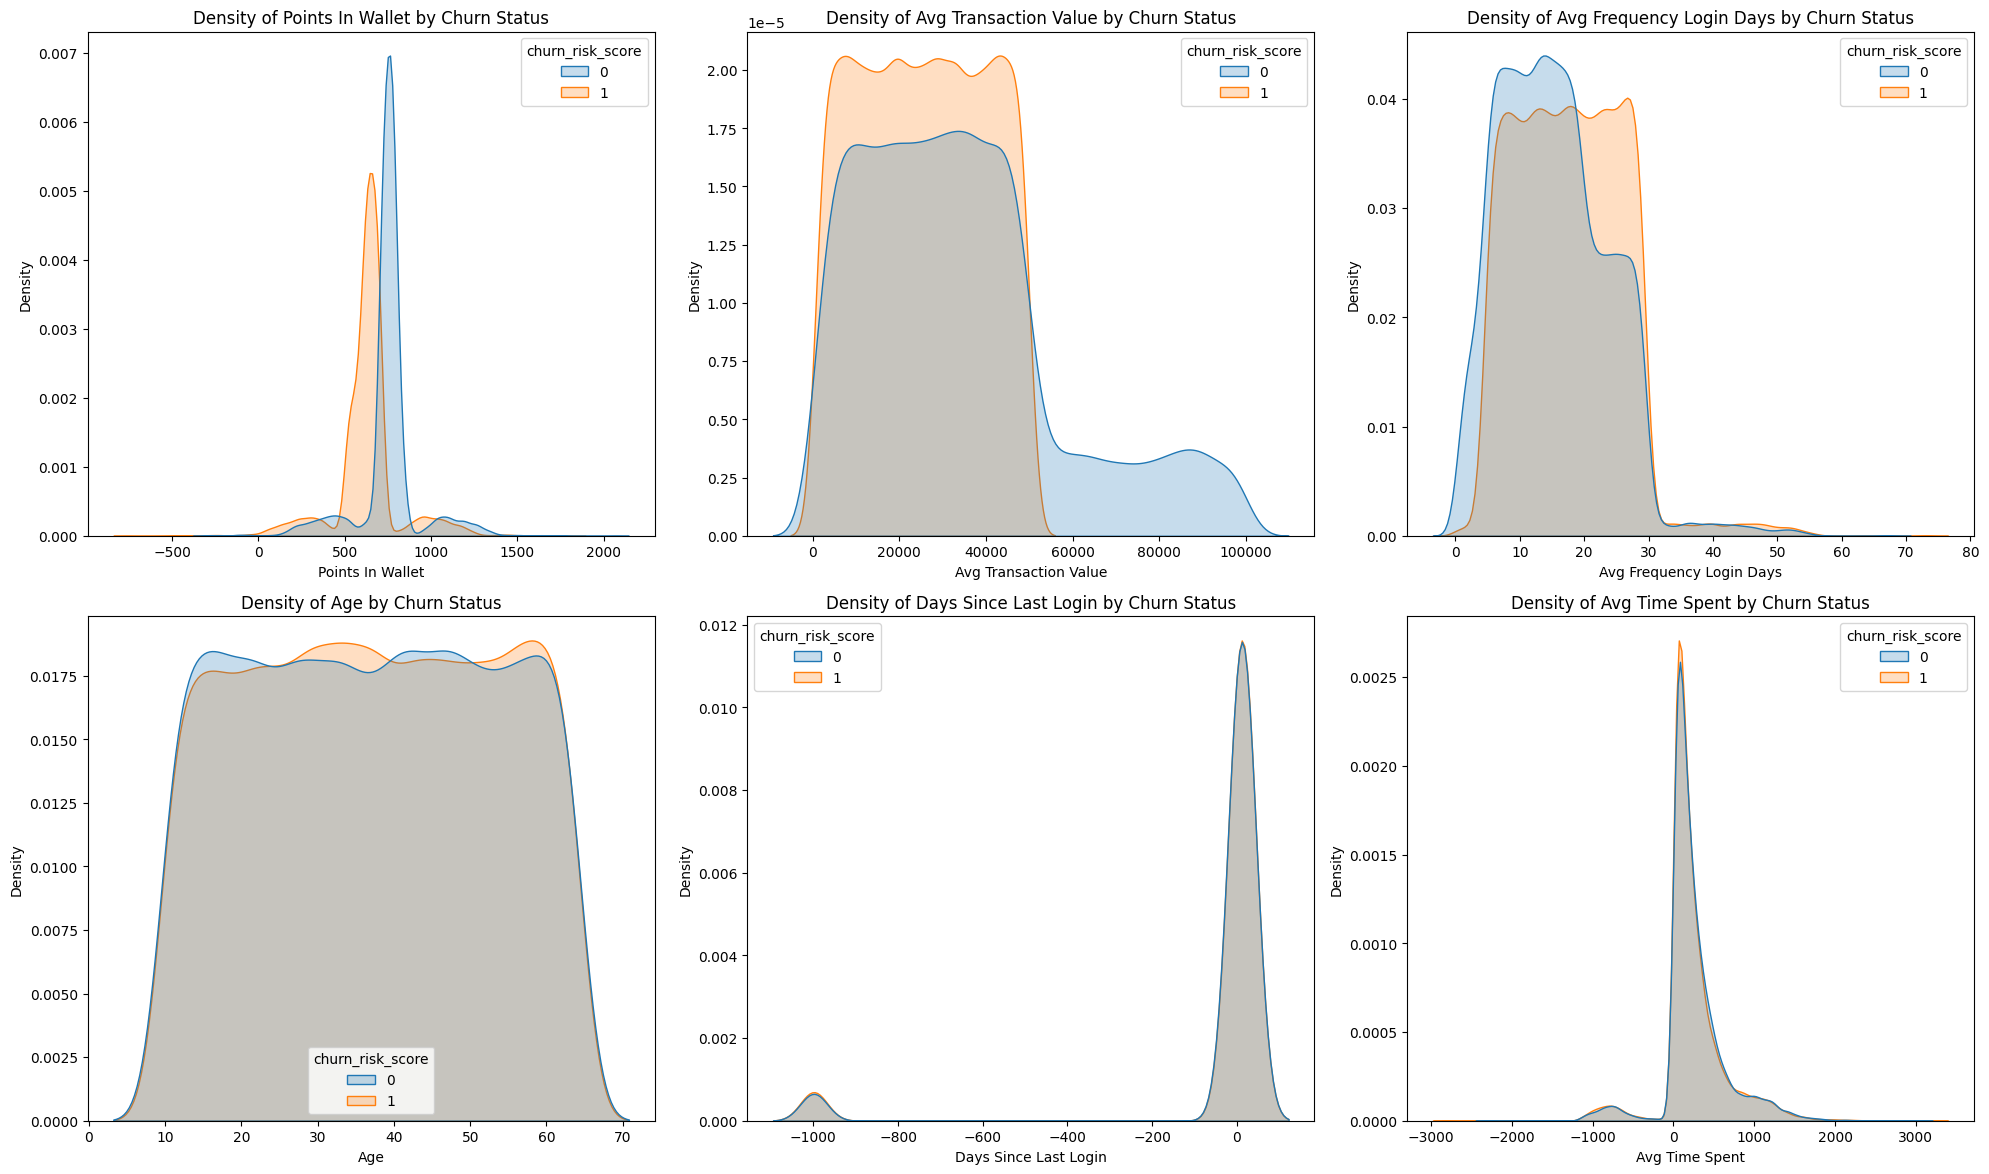

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assumes 'merged_df2' is your preprocessed DataFrame
# containing both numerical features and the 'churn_risk_score' column.

numerical_features = [
    "points_in_wallet",
    "avg_transaction_value",
    "avg_frequency_login_days",
    "age",
    "days_since_last_login",
    "avg_time_spent"
]
# to remove 'Error' entries in 'avg_frequency_login_days' column to avoid data type error
processed_merged_df = merged_df.copy(deep=True)
processed_merged_df['avg_frequency_login_days'] = processed_merged_df['avg_frequency_login_days'].apply(lambda x:x if x!='Error' else -1)
processed_merged_df['avg_frequency_login_days'] = processed_merged_df['avg_frequency_login_days'].astype('float')
processed_merged_df['avg_frequency_login_days'] = processed_merged_df['avg_frequency_login_days'].apply(lambda x:x if x>=0 else np.nan)

# --- Overlaid Kernel Density Estimation (KDE) Plot ---
# --- Create a 2x3 grid of subplots ---
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Loop through each feature and its corresponding subplot axis
for i, feature in enumerate(numerical_features):
    ax = axes[i] # Select the current subplot
    
    # Generate the KDE Plot on the specific subplot 'ax'
    sns.kdeplot(data=processed_merged_df, x=feature, hue='churn_risk_score', 
                fill=True, common_norm=False, ax=ax)

    # Set titles and labels dynamically for the current subplot
    ax.set_title(f'Density of {feature.replace("_", " ").title()} by Churn Status')
    ax.set_xlabel(f'{feature.replace("_", " ").title()}')
    ax.set_ylabel('Density')

# Hide the last unused subplot
# This will turn off the axis for the 6th plot since we only have 5 features
for i in range(len(numerical_features), len(axes)):
    axes[i].axis('off')

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout()

# Display the single figure containing all the plots
plt.show()

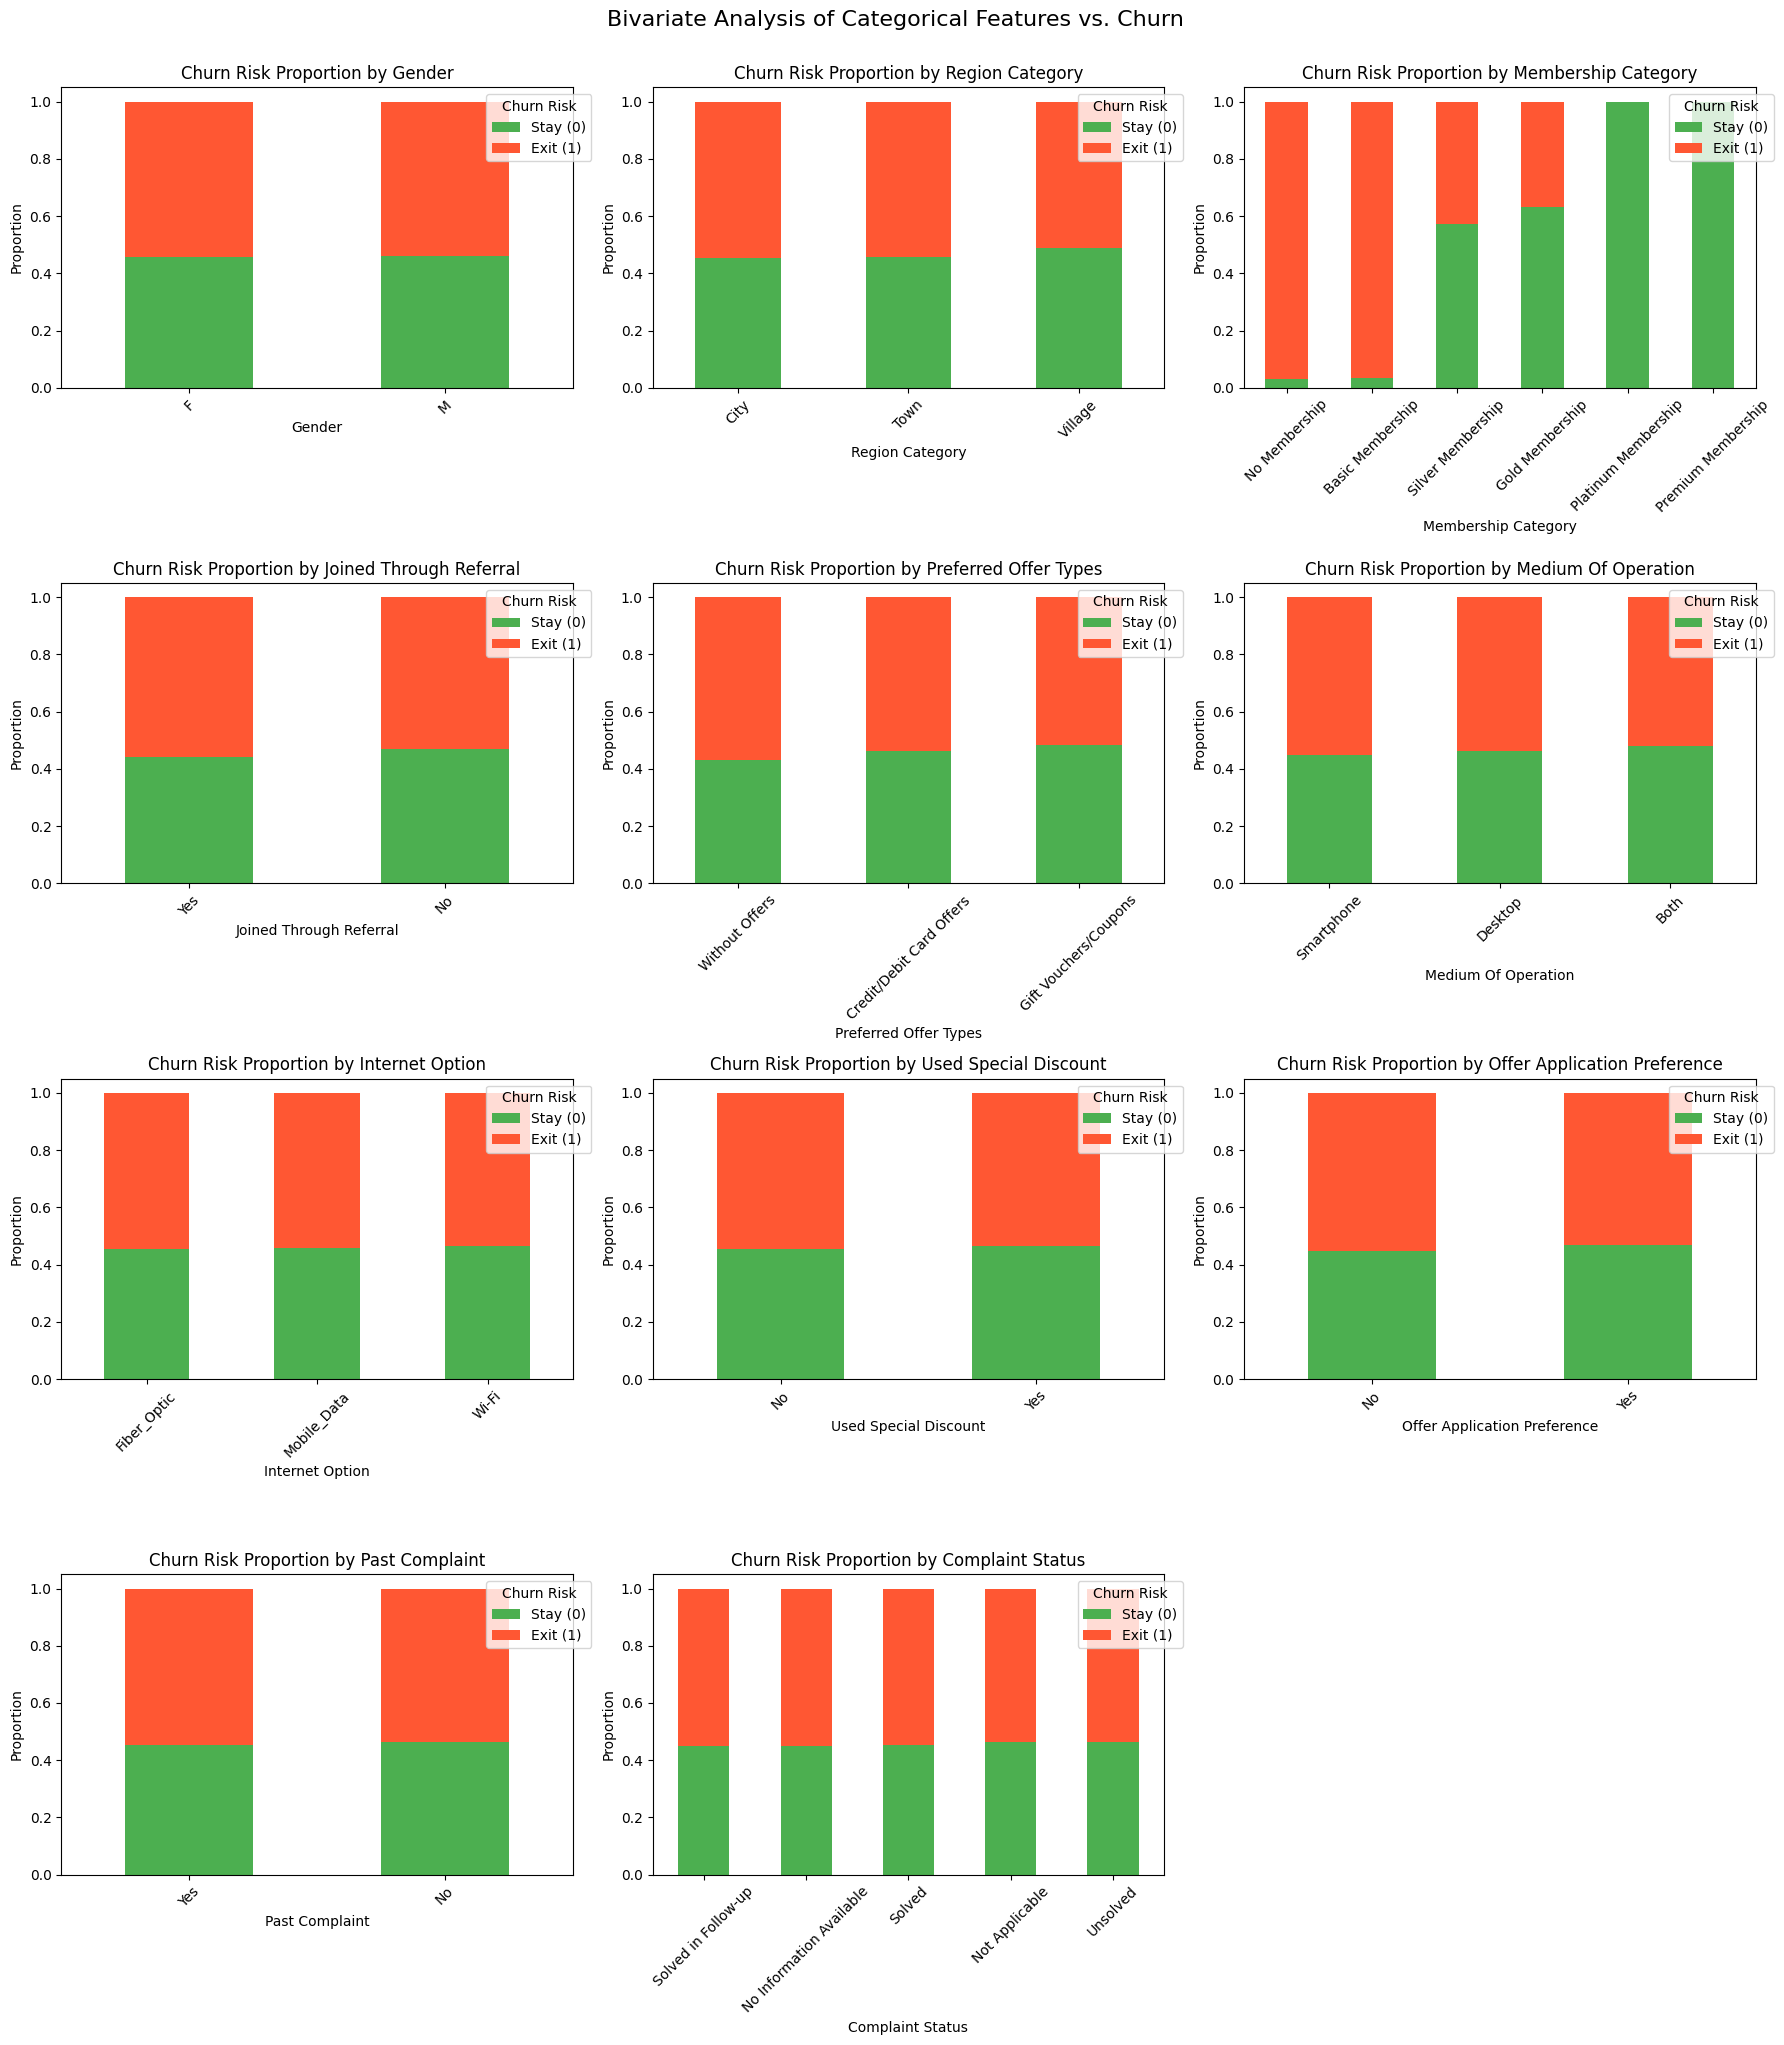

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame after initial data loading
# and 'churn_risk_score' is your target variable

# Define the list of all categorical features to analyze against the churn score

categorical_features = [
    'gender',
    'region_category',
    'membership_category',
    #'joining_date', # Note; too many unique values in this feature, not suitable for this plot
    'joined_through_referral',
    #'last_visit_time', # Note; too many unique values in this feature, not suitable for this plot
    'preferred_offer_types',
    'medium_of_operation',
    'internet_option',
    'used_special_discount',
    'offer_application_preference',
    'past_complaint',
    'complaint_status' 
]

# Determine the number of rows and columns for the subplot grid
# Aim for roughly 3 columns to keep plots readable
n_features = len(categorical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Loop through each categorical feature and create a stacked bar plot
for i, column in enumerate(categorical_features):
    ax = axes[i] # Select the current subplot

    # Create a crosstab and normalize by index to get proportions within each category
    crosstab_normalized = pd.crosstab(
        index=merged_df[column],
        columns=merged_df['churn_risk_score'],
        normalize='index'
    )

    # Sort by churn (1) in descending order to highlight high-churn categories
    crosstab_normalized = crosstab_normalized.sort_values(by=1, ascending=False)

    # Plotting the stacked bar chart
    crosstab_normalized.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=['#4CAF50', '#FF5733'] # Green for 0 (no churn), Red for 1 (churn)
    )

    ax.set_title(f'Churn Risk Proportion by {column.replace("_", " ").title()}')
    ax.set_xlabel(column.replace("_", " ").title())
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Churn Risk', labels=['Stay (0)', 'Exit (1)'], loc='upper right', bbox_to_anchor=(1.05, 1))


# Hide any unused subplots if the number of features is not a perfect multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent titles/labels from overlapping
plt.suptitle('Bivariate Analysis of Categorical Features vs. Churn', y=1.02, fontsize=16) # Overall title
plt.show()

In [17]:
# 1. Define the list of all categorical features to analyze against the churn score

# Loop through each feature and create a cross-tabulation with the churn_risk_score
print("--- Bivariate Analysis of Categorical Features vs. Churn ---")
for column in categorical_features:
    print(f"\n--- Distribution of '{column}' by Churn Status ---")
    # pandas.crosstab creates a frequency table showing the relationship
    # between the feature (index) and the churn score (columns).
    crosstab_result = pd.crosstab(index=merged_df[column], columns=merged_df['churn_risk_score'])
    
    # Sort the table by the churn column (1) in descending order
    sorted_crosstab = crosstab_result.sort_values(by=1, ascending=False)
    print(sorted_crosstab)


#1. As we can see both genders, `Male` and `Female` are equally distributed and there is some noise which will be handled in [Section 6.1.2](#NS_Missing_Values)
#2. Most of the customers are from town region while least number of customer belongs to village whcih is ~4600. 
#3. No & Basic category are leading one in `membership_category` while premium & platinum are least subscribed which is around ~4300+ 
#4. Around 15K customers have joined through referral program
#5. Most of the customers either use Desktop or Smartphone to access website
#6. Most of the customers has given negative feedback about the service such as `poor website`, `poor customer service` etc.

--- Bivariate Analysis of Categorical Features vs. Churn ---

--- Distribution of 'gender' by Churn Status ---
churn_risk_score     0      1
gender                       
F                 8441  10049
M                 8508   9934
Unknown             30     29

--- Distribution of 'region_category' by Churn Status ---
churn_risk_score     0     1
region_category             
Town              6469  7658
City              5768  6969
Village           2293  2406

--- Distribution of 'membership_category' by Churn Status ---
churn_risk_score        0     1
membership_category            
Basic Membership      251  7473
No Membership         226  7466
Silver Membership    3427  2560
Gold Membership      4282  2513
Platinum Membership  4338     0
Premium Membership   4455     0

--- Distribution of 'joining_date' by Churn Status ---
churn_risk_score   0   1
joining_date            
2/6/2015          20  35
28/3/2016         16  31
5/11/2016         16  31
26/6/2015         19  30
3/8/2016  

### 5.5.2 Data Distribution of Target <a id='dist_target'></a>

In [18]:
print(merged_df['churn_risk_score'].value_counts(), "\n")

print(merged_df['churn_risk_score'].value_counts(normalize=True))
# Target feature **churn_risk_score**'s classes `Customer will Exit (1)` and `Customer won't exit (0)` are kind of equally distributed

churn_risk_score
1    20012
0    16979
Name: count, dtype: int64 

churn_risk_score
1    0.540996
0    0.459004
Name: proportion, dtype: float64


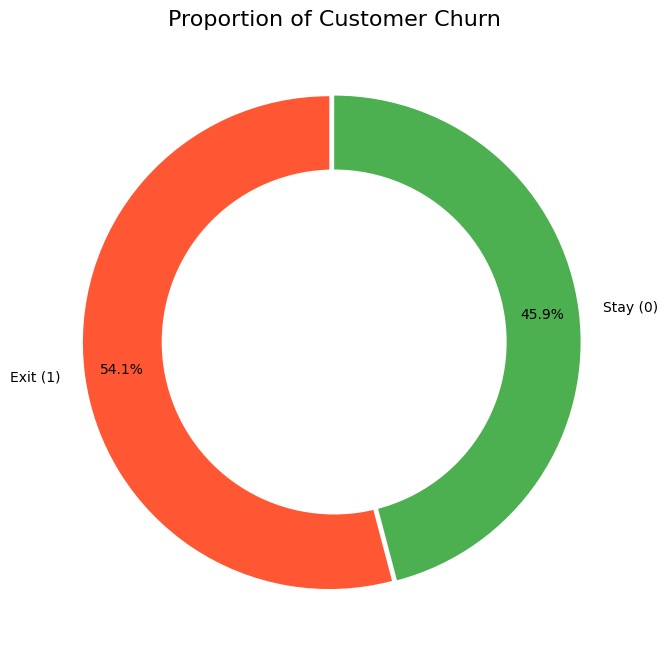

In [19]:
import matplotlib.pyplot as plt

# Get the value counts
churn_counts = merged_df['churn_risk_score'].value_counts()

# Define labels and colors
labels = ['Exit (1)', 'Stay (0)']
colors = ['#FF5733', '#4CAF50']

plt.figure(figsize=(8, 8))

# Create the pie chart
plt.pie(churn_counts, 
        labels=labels, 
        colors=colors,
        autopct='%1.1f%%',  # Show percentages with one decimal place
        startangle=90,      # Start the first slice at the top
        pctdistance=0.85,   # Distance of the percentage text from the center
        explode=(0.02, 0))  # Slightly separate the 'Exit' slice

# Add a circle in the center to make it a donut chart (optional, but looks nice)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Proportion of Customer Churn', fontsize=16)
plt.show()

# 6.0 Data Preprocessing <a id='data_pre'></a>

## 6.1 Missing values <a id='Missing_Values'></a>

### 6.1.1 Standard Missing Values  <a id='S_Missing_Values'></a>

In [20]:
missing_values = pd.DataFrame({
    'missing_values':merged_df.isnull().sum(),
    'percentage': merged_df.isnull().sum()*100/merged_df.shape[0]
})

missing_values.sort_values(by='missing_values', ascending=False)

,missing_values,percentage
region_category,5428,14.673840
points_in_wallet,3443,9.307669
preferred_offer_types,288,0.778568
id,0,0.000000
days_since_last_login,0,0.000000
churn_risk_score,0,0.000000
complaint_status,0,0.000000
past_complaint,0,0.000000
offer_application_preference,0,0.000000
used_special_discount,0,0.000000


Above datafram shows that missing values which are `NaN` values but there are some non-standard missing values which needs to be treated before further processing.

### 6.1.2 Non-Standard Missing Values <a id='NS_Missing_Values'></a>

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
The non-standard missing values are replaced with NaN                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [21]:
merged_df.joined_through_referral.value_counts()

joined_through_referral
No     15838
Yes    15715
?       5438
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                      The feature joined_through_referral has unindentified '?' values which are replaced with Nan.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [22]:
merged_df['joined_through_referral'] = merged_df['joined_through_referral'].replace('?',np.nan)

In [23]:
merged_df.gender.value_counts()

gender
F          18490
M          18442
Unknown       59
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature gender has unindentified 'Unknown' values which are replaced with Nan. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [24]:
merged_df['gender'] = merged_df['gender'].replace('Unknown',np.nan)

In [25]:
merged_df.referral_id.unique()

array(['xxxxxxxx', 'CID21329', 'CID12313', ..., 'CID60808', 'CID10431',
       'CID45477'], dtype=object)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature referral_id has unindentified 'xxxxxxxx' values which are replaced with Nan.
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [26]:
merged_df['referral_id'] = merged_df['referral_id'].replace('xxxxxxxx',np.nan)  

In [27]:
merged_df.medium_of_operation.value_counts()

medium_of_operation
Desktop       13912
Smartphone    13876
?              5393
Both           3810
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>    
The feature medium_of_operation has unindentified '?' values which are replaced with Nan. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [28]:
merged_df['medium_of_operation'] = merged_df['medium_of_operation'].replace('?',np.nan)  

In [29]:
merged_df.days_since_last_login.value_counts()

days_since_last_login
 12     2380
 13     2373
 14     2307
 15     2277
 11     2262
 10     2091
 16     2068
-999    1999
 9      1863
 17     1747
 8      1571
 18     1444
 7      1442
 19     1308
 6      1257
 5      1234
 20     1184
 21     1015
 4       998
 22      895
 3       852
 23      727
 2       613
 24      471
 1       328
 25      203
 26       82
Name: count, dtype: int64

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature days_since_last_login has unindentified '-999' values which are replaced with Nan. 
                   </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [30]:
merged_df['days_since_last_login'] = merged_df['days_since_last_login'].replace(-999,np.nan)  

In [31]:
len(merged_df[merged_df.avg_time_spent < 0]['avg_time_spent'])

1719

In [32]:
merged_df['avg_time_spent'] = merged_df['avg_time_spent'].apply(lambda x:x if x>=0 else np.nan)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature avg_time_spent has negative values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [33]:
len(merged_df[merged_df.points_in_wallet < 0]['points_in_wallet'])

136

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature points_in_wallet has negative values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [34]:
merged_df['points_in_wallet'] = merged_df['points_in_wallet'].apply(lambda x:x if x>=0 else np.nan)

<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        The feature avg_frequency_login_days has negative values as well as unidentified 'Error' values which are replaced with Nan
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [35]:
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].apply(lambda x:x if x!='Error' else -1)
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].astype('float')
merged_df['avg_frequency_login_days'] = merged_df['avg_frequency_login_days'].apply(lambda x:x if x>=0 else np.nan)

In [36]:
missing_values = pd.DataFrame({
    'missing_values': merged_df.isnull().sum(),
    'percentage': merged_df.isnull().sum()*100/merged_df.shape[0]
})

missing_values.sort_values(by='missing_values', ascending=False)

,missing_values,percentage
referral_id,17845,48.241464
joined_through_referral,5438,14.700873
region_category,5428,14.673840
medium_of_operation,5393,14.579222
avg_frequency_login_days,4204,11.364927
points_in_wallet,3579,9.675326
days_since_last_login,1999,5.404017
avg_time_spent,1719,4.647076
preferred_offer_types,288,0.778568
gender,59,0.159498


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
                        There are 10 features that has missing values. referral_id has the most missing values around 48%. 
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

### 6.1.3 Missing values imputation <a id='impute'></a>

**Missing values treatment for categorical variable**

In [37]:
Missing_cat = merged_df[['gender','preferred_offer_types',
                         'region_category','joined_through_referral',
                         'medium_of_operation']]
for i,col in enumerate(Missing_cat):
    merged_df[col].fillna(merged_df[col].mode()[0], inplace=True)

**Missing values treatment for numerical variable**

In [38]:
Missing_num = merged_df[['points_in_wallet','avg_time_spent',
                'days_since_last_login','avg_frequency_login_days']]

In [39]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed_value=imputer.fit_transform(Missing_num)

1. For imputing missing values for categorical features we have used mode value
2. For imputing missing values for numerical featurers we have used `KNNimputer` after experimenting with other imputation methods such as `mean` & `median` and we got better results with KNNimputer.

In [40]:
d1 = pd.DataFrame({
    'avg_frequency_login_days':imputed_value.T[0],
    'points_in_wallet':imputed_value.T[1],
    'days_since_last_login':imputed_value.T[2],
    'avg_time_spent':imputed_value.T[3]

})

# not dropping id here because we will need it as the unique identifier to merge the textual data with the structured data
merged_df.drop(['avg_frequency_login_days','points_in_wallet','days_since_last_login','avg_time_spent'], axis=1, inplace=True)

merged_df2 = pd.concat([merged_df, d1], axis=1)

## 6.2 Handle Duplicate Data

In [41]:
merged_df2[merged_df2.duplicated()]

,id,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,feedback,avg_frequency_login_days,points_in_wallet,days_since_last_login,avg_time_spent


<table align="left">
    <tr>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>
There is no duplication in dataset.                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>



## 6.3 Feature Engineering  <a id='feature_eng'></a>

In [42]:
merged_df2.joining_date

0         17/8/2017
1         28/8/2017
2        11/11/2016
3        29/10/2016
4         12/9/2017
            ...    
36986      7/9/2015
36987     21/9/2017
36988     27/6/2016
36989     11/9/2016
36990     15/6/2017
Name: joining_date, Length: 36991, dtype: object

In [43]:
# Convert joining_date to datetime format
merged_df2['joining_date'] = pd.to_datetime(merged_df2['joining_date'], dayfirst=True, errors='coerce')

# Now extract the year difference
merged_df2['years_since_joining'] = 2021 - merged_df2['joining_date'].dt.year

In [44]:
merged_df2.drop(['security_no','joining_date','referral_id',
           'last_visit_time'], axis=1, inplace=True)

1. Created new feature `years_since_joining` from joining_date 
2. Dropped features such as security_no, referral_id etc. because either they aren't valuable for predicting churn or having major missing values.

## 6.4 Outliers <a id='out'></a>

### 6.4.1 Discovery of Outliers <a id='dis_out'></a>

In [45]:
df_num = merged_df2.select_dtypes(include=[np.number]) 

In [46]:
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75) 
IQR = Q3 - Q1 

outlier = pd.DataFrame((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR)))
for i in outlier.columns:
    print(f'Total number of Outliers in column {i} are {len(outlier[outlier[i] == True][i])}')

Total number of Outliers in column id are 0
Total number of Outliers in column age are 0
Total number of Outliers in column avg_transaction_value are 1131
Total number of Outliers in column churn_risk_score are 0
Total number of Outliers in column avg_frequency_login_days are 4421
Total number of Outliers in column points_in_wallet are 2907
Total number of Outliers in column days_since_last_login are 0
Total number of Outliers in column avg_time_spent are 417
Total number of Outliers in column years_since_joining are 0


### 6.4.2 Visualizing outliers using Boxplots <a id='viz'></a>

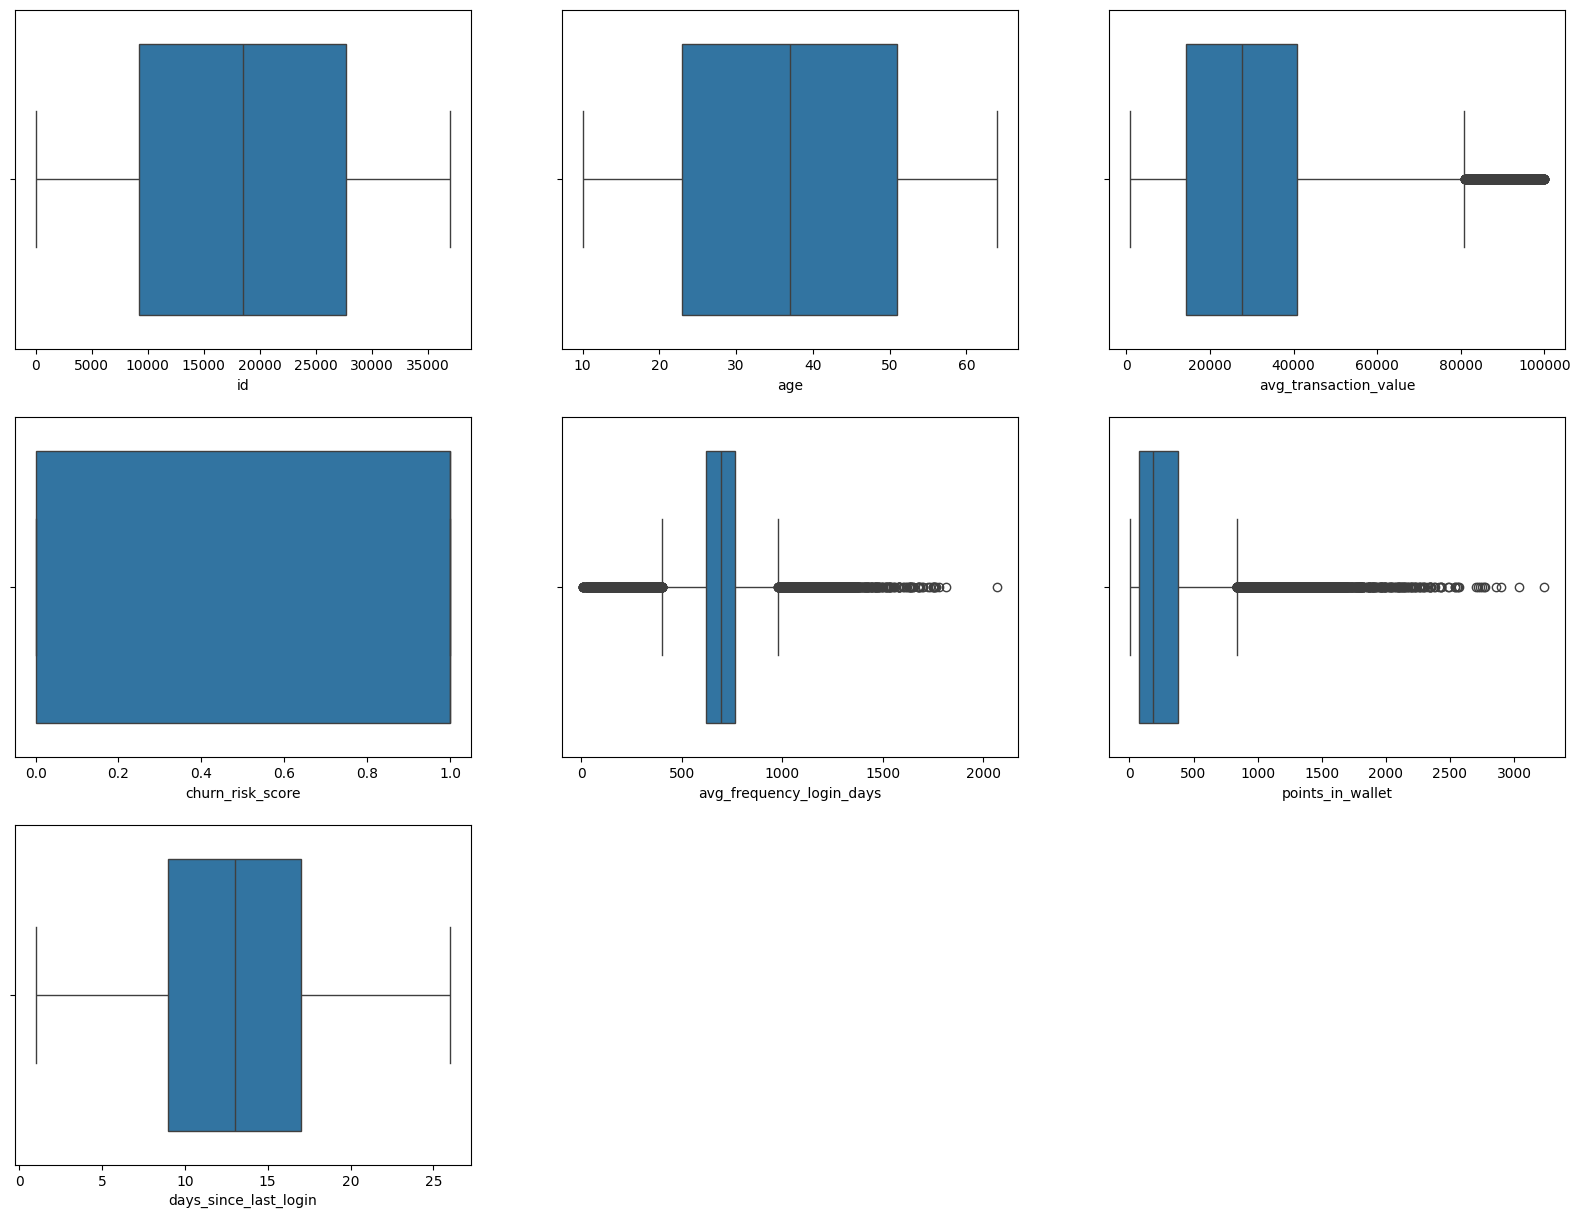

In [47]:
fig,ax= plt.subplots(nrows=3,ncols=3,figsize=(20, 15)) 
for variable, subplot in zip(df_num.columns,ax.flatten()):
    z = sns.boxplot(x = df_num[variable], orient = "h",whis=1.5 , ax=subplot) 
    z.set_xlabel(variable, fontsize = 10)
    
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
plt.show()

1. Features such as `age`, `day_since_last_login` have no outliers
2. `points in wallet` and `avg frequency login days` are having outliers in large numbers, which will be treated in next section

## 6.5 Categorical Data Encoding  <a id='cat_enc'></a>

In [48]:
df_cat = merged_df2[['gender','region_category','joined_through_referral','preferred_offer_types',
                     'medium_of_operation','internet_option','used_special_discount',
                     'offer_application_preference','past_complaint']]
df_num = merged_df2.select_dtypes(include=np.number)

In [49]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 

orderencoding_membership_category = OrdinalEncoder(categories = [["No Membership", "Basic Membership", "Silver Membership", "Gold Membership","Platinum Membership","Premium Membership"]])
merged_df2['membership_category'] = orderencoding_membership_category.fit_transform(merged_df2['membership_category'].values.reshape(-1,1))

orderencoding_complaint_status = OrdinalEncoder(categories = [["No Information Available", "Not Applicable", "Unsolved","Solved","Solved in Follow-up"]])
merged_df2['complaint_status'] = orderencoding_complaint_status.fit_transform(merged_df2['complaint_status'].values.reshape(-1,1)) 

df_categorical = pd.get_dummies(df_cat, drop_first=True, dtype=int)

1. For features such as `membership_category` and `complaint_status` we have used **OrdinalEncoder** because there is kind hierarchy in which we can order classes of these features.
2. We have used dummy encoded features such as age, region, medium_of_operation, and internet_option etc.

In [50]:
merged_df_final = pd.concat([df_categorical, df_num,
                             merged_df2['membership_category'], 
                             merged_df2['complaint_status'], 
                             merged_df2['feedback']], axis=1)

## 6.6 Feature Scaling  <a id='fea_sca'></a>

In [51]:
col = merged_df_final[['age','days_since_last_login',
                       'avg_time_spent','avg_transaction_value',
                       'avg_frequency_login_days','points_in_wallet']]

merged_df_final.drop(['age','days_since_last_login','avg_time_spent',
                      'avg_transaction_value','avg_frequency_login_days',
                      'points_in_wallet'], axis=1, inplace=True)

In [52]:
standard_scale = StandardScaler() 
col1 = standard_scale.fit_transform(col) 
merged_df_scaled = pd.DataFrame(col1, columns=col.columns)

In [53]:
merged_df_scaled.head()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
0,-1.204873,0.775608,0.063415,1.220580,0.510019,0.016363
1,-0.322562,0.592715,-0.804787,-0.845160,-0.880395,0.033783
2,0.433705,0.226928,0.683559,-0.424028,-1.045753,0.673908
3,-0.007450,-0.321751,-1.300902,-0.207380,-0.675049,-0.738290
4,-0.385584,1.324288,-0.060614,-0.246256,-0.146974,-0.555667


In [54]:
merged_data_final = pd.concat([merged_df_final, 
                            merged_df_scaled], axis=1 )

In [55]:
merged_data_final.head()

,gender_M,region_category_Town,region_category_Village,joined_through_referral_Yes,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Mobile_Data,internet_option_Wi-Fi,...,years_since_joining,membership_category,complaint_status,feedback,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
0,0,0,1,0,1,0,1,0,0,1,...,4,4.0,1.0,I’ve always appreciated the quality of custome...,-1.204873,0.775608,0.063415,1.220580,0.510019,0.016363
1,0,0,0,0,1,0,1,0,1,0,...,4,5.0,3.0,I’ve been a regular user of your website for a...,-0.322562,0.592715,-0.804787,-0.845160,-0.880395,0.033783
2,0,1,0,1,1,0,1,0,0,1,...,5,0.0,4.0,I've been frustrated with the website's perfor...,0.433705,0.226928,0.683559,-0.424028,-1.045753,0.673908
3,1,0,0,1,1,0,1,0,1,0,...,5,0.0,2.0,I’ve been a regular user of your website for a...,-0.007450,-0.321751,-1.300902,-0.207380,-0.675049,-0.738290
4,0,0,0,0,0,0,0,1,1,0,...,4,0.0,3.0,No reason specified,-0.385584,1.324288,-0.060614,-0.246256,-0.146974,-0.555667


In [56]:
# output the cleaned data

merged_data_final.to_csv("../../data/processed/cleaned_data.csv.gz", compression="gzip", index=False)

# 7.0 Preparation for Modeling <a id='eval'></a> 

In [57]:
X = merged_data_final.drop(['churn_risk_score'] ,axis = 1)
y = merged_data_final['churn_risk_score']

## 7.1 Train test validation split with stratified sampling

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
                    X, y, train_size=0.6, 
                    stratify= y,
                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(
                    X_temp, y_temp, train_size=0.5,
                    stratify=y_temp,
                    random_state=42)


In [59]:
# Export train and test dataset to `data` folder
pd.concat([X_train, y_train], axis=1).to_csv("../../data/input/train.csv.gz", index=False)
pd.concat([X_valid, y_valid], axis=1).to_csv("../../data/input/valid.csv.gz", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("../../data/input/test.csv.gz", index=False)

## 7.2 Text Representation with LLM embedding

### 7.2.1 Generate LLM embedding for synthentic 'feedback' column

In [60]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_TRAIN = "../../data/processed/llm_embedding_train.csv.gz"
if os.path.exists(EMBEDDING_TRAIN):
    pass
else:
    processed_text_series = pd.Series(X_train["feedback"].to_list(),
                                    index=X_train['id'].to_list()) 
    llm_embedding_train = generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_train.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_train.csv.gz",
                            max_workers=20)
    print(llm_embedding_train)
    

In [61]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_VALID = "../../data/processed/llm_embedding_valid.csv.gz"
if os.path.exists(EMBEDDING_VALID):
    pass
else:
    processed_text_series = pd.Series(X_valid["feedback"].to_list(),
                                    index=X_valid['id'].to_list()) 
    llm_embedding_valid = generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_valid.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_valid.csv.gz",
                            max_workers=20)
    print(llm_embedding_valid)

In [62]:
import os
import pandas as pd 
from utils.prepare_llm_embedding import generate_embeddings_from_series 

EMBEDDING_TEST = "../../data/processed/llm_embedding_test.csv.gz"
if os.path.exists(EMBEDDING_TEST):
    pass
else:
    processed_text_series = pd.Series(X_test["feedback"].to_list(),
                                    index=X_test['id'].to_list())
    llm_embedding_test= generate_embeddings_from_series(processed_text_series,
                            additional_data={"churn_risk_score": y_test.to_list()},
                            output_csv_path="../../data/processed/llm_embedding_test.csv.gz",
                            max_workers=20)
    print(llm_embedding_test)

### 7.2.2 Combine LLM embeddings with structured data

In [63]:
train_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_train.csv.gz", compression="gzip")
valid_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_valid.csv.gz", compression="gzip")
test_text_vectorized = pd.read_csv("../../data/processed/llm_embedding_test.csv.gz", compression="gzip")

In [64]:
import ast

# Create train df which combines all structured data and textual data
train_df = pd.merge(X_train, train_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')
train_df['embedding_json'] = train_df['embedding_json'].apply(ast.literal_eval)

# create dataframe with columns with 'unstructured data'
X_train_unstructured_llm_embedding = pd.DataFrame(train_df['embedding_json'].tolist())
X_train_unstructured_llm_embedding.columns = [f"text_feature_{i+1}" for i in range(X_train_unstructured_llm_embedding.shape[1])]

# create dataframe with columns with 'structured data'
X_train_structured = train_df.drop(columns=['feedback', 'embedding_json', 'churn_risk_score'])

# Concatenate with both dataframe with structured and unstructured data
X_train_vectorized = pd.concat([X_train_structured, X_train_unstructured_llm_embedding], axis=1).drop(columns=['id'])
X_train_vectorized_with_id = pd.concat([X_train_structured, X_train_unstructured_llm_embedding], axis=1)

# Create target variable
y_train = train_df['churn_risk_score']

In [65]:
# Create validation df which combines all structured data and textual data
valid_df = pd.merge(X_valid, valid_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')
valid_df['embedding_json'] = valid_df['embedding_json'].apply(ast.literal_eval)

# create dataframe with columns with 'unstructured data'
X_valid_unstructured_llm_embedding = pd.DataFrame(valid_df['embedding_json'].tolist())
X_valid_unstructured_llm_embedding.columns = [f"text_feature_{i+1}" for i in range(X_valid_unstructured_llm_embedding.shape[1])]

# create dataframe with columns with 'structured data'
X_valid_structured = valid_df.drop(columns=['feedback', 'embedding_json', 'churn_risk_score'])

# Concatenate with both dataframe with structured and unstructured data
X_valid_vectorized  = pd.concat([X_valid_structured, X_valid_unstructured_llm_embedding], axis=1).drop(columns=['id'])
X_valid_vectorized_with_id  = pd.concat([X_valid_structured, X_valid_unstructured_llm_embedding], axis=1)

# Create target variable
y_valid = valid_df['churn_risk_score']

In [66]:
# Create test df which combines all structured data and textual data
test_df = pd.merge(X_test, test_text_vectorized[['id', 'embedding_json', 'churn_risk_score']], on='id', how='outer')
test_df['embedding_json'] = test_df['embedding_json'].apply(ast.literal_eval)

# create dataframe with columns with 'unstructured data'
X_test_unstructured_llm_embedding = pd.DataFrame(test_df['embedding_json'].tolist())
X_test_unstructured_llm_embedding.columns = [f"text_feature_{i+1}" for i in range(X_test_unstructured_llm_embedding.shape[1])]

# create dataframe with columns with 'structured data'
X_test_structured = test_df.drop(columns=['feedback', 'embedding_json', 'churn_risk_score'])

## Concatenate with original dataframe (drop embedding_json)
X_test_vectorized = pd.concat([X_test_structured, X_test_unstructured_llm_embedding], axis=1).drop(columns=['id'])
X_test_vectorized_with_id = pd.concat([X_test_structured, X_test_unstructured_llm_embedding], axis=1)

# Create target variable
y_test = test_df['churn_risk_score']

# 8.0 Modeling

## 8.1 Modeling on structured data

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_structured, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_structured)
y_valid_pred_lr = lr_model.predict(X_valid_structured)
y_test_pred_lr = lr_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.8453
Validation Accuracy:  0.8483
Test Accuracy:  0.8443

Train F1-score: 0.8451
Validation F1-score:  0.8482
Test F1-score:  0.8442

Train Precision: 0.8452
Validation Precision:  0.8482
Test Precision:  0.8442

Train Recall: 0.8453
Validation Recall:  0.8483
Test Recall:  0.8443

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3396
           1       0.85      0.86      0.86      4003

    accuracy                           0.84      7399
   macro avg       0.84      0.84      0.84      7399
weighted avg       0.84      0.84      0.84      7399

Confusion Matrix (Test):
[[2794  602]
 [ 550 3453]]


(ii) Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)
dt_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_structured)
y_valid_pred_dt = dt_model.predict(X_valid_structured)
y_test_pred_dt = dt_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.9333
Valid Accuracy:  0.9305
Test Accuracy:  0.9315

Train F1-score: 0.9332
Valid F1-score:  0.9304
Test F1-score:  0.9314

Train Precision: 0.9334
Valid Precision:  0.9308
Test Precision:  0.9316

Train Recall: 0.9333
Valid Recall:  0.9305
Test Recall:  0.9315

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3396
           1       0.93      0.95      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3099  297]
 [ 210 3793]]


(iii) Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )
rf_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_structured)
y_valid_pred_rf = rf_model.predict(X_valid_structured)
y_test_pred_rf = rf_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.9313
Valid Accuracy:  0.9290
Test Accuracy:  0.9308

Train F1-score: 0.9314
Valid F1-score:  0.9290
Test F1-score:  0.9308

Train Precision: 0.9314
Valid Precision:  0.9290
Test Precision:  0.9309

Train Recall: 0.9313
Valid Recall:  0.9290
Test Recall:  0.9308

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3396
           1       0.94      0.93      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3156  240]
 [ 272 3731]]


(iv) XGBoost

In [70]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_structured, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_structured)
y_valid_pred_xgb = xgb_model.predict(X_valid_structured)
y_test_pred_xgb = xgb_model.predict(X_test_structured)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 1.0000
Valid Accuracy:  0.9258
Test Accuracy:  0.9308

Train F1-score: 1.0000
Valid F1-score:  0.9256
Test F1-score:  0.9307

Train Precision: 1.0000
Valid Precision:  0.9265
Test Precision:  0.9312

Train Recall: 1.0000
Valid Recall:  0.9258
Test Recall:  0.9308

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3396
           1       0.92      0.95      0.94      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3073  323]
 [ 189 3814]]


## 8.2 Modeling on unstructured data

(i) Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_lr = lr_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_lr = lr_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.5528
Validation Accuracy:  0.5301
Test Accuracy:  0.5366

Train F1-score: 0.4595
Validation F1-score:  0.4314
Test F1-score:  0.4389

Train Precision: 0.5579
Validation Precision:  0.4932
Test Precision:  0.5115

Train Recall: 0.5528
Validation Recall:  0.5301
Test Recall:  0.5366

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.47      0.09      0.15      3396
           1       0.54      0.91      0.68      4003

    accuracy                           0.54      7399
   macro avg       0.51      0.50      0.42      7399
weighted avg       0.51      0.54      0.44      7399

Confusion Matrix (Test):
[[ 311 3085]
 [ 344 3659]]


(ii) Decision Tree

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)
dt_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_dt = dt_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_dt = dt_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.6272
Valid Accuracy:  0.5176
Test Accuracy:  0.5117

Train F1-score: 0.6215
Valid F1-score:  0.5095
Test F1-score:  0.5037

Train Precision: 0.6257
Valid Precision:  0.5103
Test Precision:  0.5042

Train Recall: 0.6272
Valid Recall:  0.5176
Test Recall:  0.5117

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.46      0.37      0.41      3396
           1       0.54      0.63      0.58      4003

    accuracy                           0.51      7399
   macro avg       0.50      0.50      0.50      7399
weighted avg       0.50      0.51      0.50      7399

Confusion Matrix (Test):
[[1250 2146]
 [1467 2536]]


(iii) Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )
rf_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_rf = rf_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_rf = rf_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.7550
Valid Accuracy:  0.5381
Test Accuracy:  0.5397

Train F1-score: 0.7330
Valid F1-score:  0.4147
Test F1-score:  0.4175

Train Precision: 0.8313
Valid Precision:  0.5090
Test Precision:  0.5167

Train Recall: 0.7550
Valid Recall:  0.5381
Test Recall:  0.5397

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.49      0.05      0.09      3396
           1       0.54      0.95      0.69      4003

    accuracy                           0.54      7399
   macro avg       0.51      0.50      0.39      7399
weighted avg       0.52      0.54      0.42      7399

Confusion Matrix (Test):
[[ 178 3218]
 [ 188 3815]]


(iv) XGBoost

In [74]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_unstructured_llm_embedding, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_unstructured_llm_embedding)
y_valid_pred_xgb = xgb_model.predict(X_valid_unstructured_llm_embedding)
y_test_pred_xgb = xgb_model.predict(X_test_unstructured_llm_embedding)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 0.9237
Valid Accuracy:  0.5119
Test Accuracy:  0.5180

Train F1-score: 0.9227
Valid F1-score:  0.5000
Test F1-score:  0.5067

Train Precision: 0.9331
Valid Precision:  0.5022
Test Precision:  0.5091

Train Recall: 0.9237
Valid Recall:  0.5119
Test Recall:  0.5180

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.47      0.35      0.40      3396
           1       0.55      0.66      0.60      4003

    accuracy                           0.52      7399
   macro avg       0.51      0.51      0.50      7399
weighted avg       0.51      0.52      0.51      7399

Confusion Matrix (Test):
[[1189 2207]
 [1359 2644]]


## 8.3 Modeling on mixed data (on structured data and textual data)

(i) Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_model.fit(X_train_vectorized, y_train)

# Predictions on training and valid sets
y_train_pred_lr = lr_model.predict(X_train_vectorized)
y_valid_pred_lr = lr_model.predict(X_valid_vectorized)
y_test_pred_lr = lr_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_lr, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_lr, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_lr, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_lr, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_lr, average='weighted')
test_precision = precision_score(y_test, y_test_pred_lr, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_lr, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_lr, average='weighted')
test_recall = recall_score(y_test, y_test_pred_lr, average='weighted')


# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Validation F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

Train Accuracy: 0.8459
Validation Accuracy:  0.8496
Test Accuracy:  0.8442

Train F1-score: 0.8458
Validation F1-score:  0.8494
Test F1-score:  0.8441

Train Precision: 0.8458
Validation Precision:  0.8495
Test Precision:  0.8441

Train Recall: 0.8459
Validation Recall:  0.8496
Test Recall:  0.8442

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3396
           1       0.85      0.86      0.86      4003

    accuracy                           0.84      7399
   macro avg       0.84      0.84      0.84      7399
weighted avg       0.84      0.84      0.84      7399

Confusion Matrix (Test):
[[2796  600]
 [ 553 3450]]


(ii) Decision Tree

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Initialize the Decision Tree
dt_model = DecisionTreeClassifier(max_depth=100, 
                                  min_samples_split=10, 
                                  criterion='entropy', 
                                  min_samples_leaf=100,
                                  random_state=42)

# Train the model
dt_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_dt = dt_model.predict(X_train_vectorized)
y_valid_pred_dt = dt_model.predict(X_valid_vectorized)
y_test_pred_dt = dt_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_dt, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_dt, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_dt, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_dt, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_dt, average='weighted')
test_precision = precision_score(y_test, y_test_pred_dt, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_dt, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_dt, average='weighted')
test_recall = recall_score(y_test, y_test_pred_dt, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_dt))

Train Accuracy: 0.9353
Valid Accuracy:  0.9263
Test Accuracy:  0.9261

Train F1-score: 0.9352
Valid F1-score:  0.9261
Test F1-score:  0.9259

Train Precision: 0.9356
Valid Precision:  0.9271
Test Precision:  0.9264

Train Recall: 0.9353
Valid Recall:  0.9263
Test Recall:  0.9261

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3396
           1       0.92      0.95      0.93      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.92      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3057  339]
 [ 208 3795]]


(iii) Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)

# Train the model
rf_model = RandomForestClassifier(max_depth=10,
                            bootstrap=False,
                            random_state=42,
                            n_jobs=-1
                            )
rf_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_rf = rf_model.predict(X_train_vectorized)
y_valid_pred_rf = rf_model.predict(X_valid_vectorized)
y_test_pred_rf = rf_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_rf, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_rf, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_rf, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_rf, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_rf, average='weighted')
test_precision = precision_score(y_test, y_test_pred_rf, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_rf, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_rf, average='weighted')
test_recall = recall_score(y_test, y_test_pred_rf, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_rf))

Train Accuracy: 0.9185
Valid Accuracy:  0.9043
Test Accuracy:  0.9046

Train F1-score: 0.9184
Valid F1-score:  0.9040
Test F1-score:  0.9044

Train Precision: 0.9186
Valid Precision:  0.9051
Test Precision:  0.9051

Train Recall: 0.9185
Valid Recall:  0.9043
Test Recall:  0.9046

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      3396
           1       0.90      0.93      0.91      4003

    accuracy                           0.90      7399
   macro avg       0.91      0.90      0.90      7399
weighted avg       0.91      0.90      0.90      7399

Confusion Matrix (Test):
[[2959  437]
 [ 269 3734]]


(iv) XGBoost

In [78]:
import xgboost as xgb
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, classification_report, confusion_matrix)

# Train the model
xgb_model = xgb.XGBClassifier(max_depth=10,
                            random_state=42,
                            # Introduce randomness to make training faster and reduce overfitting
                            subsample=0.8, ## Uses 80% of the data for each tree.
                            colsample_bytree=0.8, ## Uses 80% of the features for each tree.
                            # the parameters below make the model trained faster by enabling parallelism
                            n_jobs = -1)
xgb_model.fit(X_train_vectorized, y_train)

# Predictions on training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_vectorized)
y_valid_pred_xgb = xgb_model.predict(X_valid_vectorized)
y_test_pred_xgb = xgb_model.predict(X_test_vectorized)

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
valid_accuracy = accuracy_score(y_valid, y_valid_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

# F1 scores
train_f1_score = f1_score(y_train, y_train_pred_xgb, average='weighted')
valid_f1_score = f1_score(y_valid, y_valid_pred_xgb, average='weighted')
test_f1_score = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Precision scores
train_precision = precision_score(y_train, y_train_pred_xgb, average='weighted')
valid_precision = precision_score(y_valid, y_valid_pred_xgb, average='weighted')
test_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Recall scores
train_recall = recall_score(y_train, y_train_pred_xgb, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred_xgb, average='weighted')
test_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')

# Output
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Valid Accuracy:  {valid_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}\n")

print(f"Train F1-score: {train_f1_score:.4f}")
print(f"Valid F1-score:  {valid_f1_score:.4f}")
print(f"Test F1-score:  {test_f1_score:.4f}\n")

print(f"Train Precision: {train_precision:.4f}")
print(f"Valid Precision:  {valid_precision:.4f}")
print(f"Test Precision:  {test_precision:.4f}\n")

print(f"Train Recall: {train_recall:.4f}")
print(f"Valid Recall:  {valid_recall:.4f}")
print(f"Test Recall:  {test_recall:.4f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_xgb))

Train Accuracy: 1.0000
Valid Accuracy:  0.9278
Test Accuracy:  0.9284

Train F1-score: 1.0000
Valid F1-score:  0.9276
Test F1-score:  0.9282

Train Precision: 1.0000
Valid Precision:  0.9286
Test Precision:  0.9287

Train Recall: 1.0000
Valid Recall:  0.9278
Test Recall:  0.9284

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3396
           1       0.92      0.95      0.93      4003

    accuracy                           0.93      7399
   macro avg       0.93      0.93      0.93      7399
weighted avg       0.93      0.93      0.93      7399

Confusion Matrix (Test):
[[3068  328]
 [ 202 3801]]


# 9.0 Cross validation with t-test statistical measure

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import ttest_rel
import warnings
import ast

warnings.filterwarnings('ignore')

# --- 1. CONFIGURATION: Define File Paths ---
CLEANED_DATA_PATH = "../../data/processed/cleaned_data.csv.gz"
TRAIN_EMBEDDINGS_PATH = "../../data/processed/llm_embedding_train.csv.gz"
VALID_EMBEDDINGS_PATH = "../../data/processed/llm_embedding_valid.csv.gz"
TEST_EMBEDDINGS_PATH = "../../data/processed/llm_embedding_test.csv.gz"

# --- 2. Load and Prepare Data ---
try:
    # Load the main dataset which includes structured features and 'id'
    cleaned_df = pd.read_csv(CLEANED_DATA_PATH, compression="gzip")
    
    # Load the LLM embeddings you generated
    train_embeddings = pd.read_csv(TRAIN_EMBEDDINGS_PATH, compression="gzip")
    valid_embeddings = pd.read_csv(VALID_EMBEDDINGS_PATH, compression="gzip")
    test_embeddings = pd.read_csv(TEST_EMBEDDINGS_PATH, compression="gzip")
    
    # Combine all embedding sets into one DataFrame
    all_embeddings = pd.concat([train_embeddings, valid_embeddings, test_embeddings], ignore_index=True)
    
    # The 'embedding_json' column is a string representation of a list, so we parse it
    all_embeddings['embedding_json'] = all_embeddings['embedding_json'].apply(ast.literal_eval)
    
    # Create a new DataFrame from the lists of embeddings
    embedding_df = pd.DataFrame(all_embeddings['embedding_json'].tolist())
    embedding_df.columns = [f"text_feature_{i+1}" for i in range(embedding_df.shape[1])]
    embedding_df['id'] = all_embeddings['id']

    # Merge the main cleaned data with the processed embeddings using 'id' as the key
    if 'id' not in cleaned_df.columns:
        print("Error: The 'id' column is missing from the cleaned dataset and is required for merging.")
        exit()
        
    final_df = pd.merge(cleaned_df.drop(columns=['feedback']), embedding_df, on='id')

except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("\nPlease check the file paths defined in the 'CONFIGURATION' section of the script.")
    print("Ensure the script is run from a location where these relative paths are correct.")
    exit()

# --- 3. Define Feature Sets and Target ---
TARGET = 'churn_risk_score'
ID_COLUMN = 'id'

# Get list of text feature columns (those generated from embeddings)
text_features = [col for col in final_df.columns if 'text_feature_' in col]

# Get list of structured feature columns (all columns except target, id, and text features)
structured_features = [col for col in final_df.columns if col not in text_features + [TARGET, ID_COLUMN]]

# Create the final data matrices for the models
X_structured = final_df[structured_features]
X_mixed = final_df[structured_features + text_features]
y = final_df[TARGET]


# --- 4. Define Models ---
# Using the same hyperparameters as in your notebook for consistency
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=100, min_samples_split=10, criterion='entropy', min_samples_leaf=100, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=10, bootstrap=False, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(max_depth=10, random_state=42, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
}


# --- 5. Perform Cross-Validation and Statistical Test ---
N_SPLITS = 10
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

results_summary = []

print("Running 10-fold cross-validation for each model...\n")

for model_name, model in models.items():
    print(f"--- Evaluating: {model_name} ---")
    
    scores_structured = []
    scores_mixed = []

    # Using a fresh model instance for each data type within the loop
    from sklearn.base import clone
    model_for_structured = clone(model)
    model_for_mixed = clone(model)

    fold_num = 1
    for train_index, test_index in skf.split(X_structured, y):
        # --- Split data for this fold ---
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # --- Evaluate on Structured Data Only ---
        X_train_structured, X_test_structured = X_structured.iloc[train_index], X_structured.iloc[test_index]
        model_for_structured.fit(X_train_structured, y_train)
        preds_structured = model_for_structured.predict(X_test_structured)
        f1_structured = f1_score(y_test, preds_structured, average='weighted')
        scores_structured.append(f1_structured)

        # --- Evaluate on Mixed Data ---
        X_train_mixed, X_test_mixed = X_mixed.iloc[train_index], X_mixed.iloc[test_index]
        model_for_mixed.fit(X_train_mixed, y_train)
        preds_mixed = model_for_mixed.predict(X_test_mixed)
        f1_mixed = f1_score(y_test, preds_mixed, average='weighted')
        scores_mixed.append(f1_mixed)
        
        print(f"  Fold {fold_num}/{N_SPLITS} -> F1 Structured: {f1_structured:.4f}, F1 Mixed: {f1_mixed:.4f}")
        fold_num += 1

    # --- Perform Paired T-test ---
    # We compare mixed vs structured to see if adding text features made a difference
    t_stat, p_value = ttest_rel(scores_mixed, scores_structured)

    # --- Store Results ---
    results_summary.append({
        "Model": model_name,
        "Mean F1 (Structured)": np.mean(scores_structured),
        "Std Dev (Structured)": np.std(scores_structured),
        "Mean F1 (Mixed)": np.mean(scores_mixed),
        "Std Dev (Mixed)": np.std(scores_mixed),
        "T-statistic": t_stat,
        "P-value": p_value
    })
    print("-" * 30)

# --- 6. Display Final Results ---
results_df = pd.DataFrame(results_summary)
print("\n--- Cross-Validation and Paired T-test Results ---")
print(results_df.to_string())

# --- 7. Interpretation ---
print("\n\n--- Interpretation Guide ---")
print("The paired t-test checks if the difference in performance between 'Structured' and 'Mixed' data is statistically significant.")
print("The Null Hypothesis (H0) is that there is no real difference in performance.")
print("\nP-value Interpretation:")
print("- A low p-value (typically < 0.05) suggests that we can reject the null hypothesis.")
print("This means the observed performance difference is statistically significant and not due to random chance.")
print("- A high p-value (>= 0.05) suggests that we cannot reject the null hypothesis.")
print("This means we don't have enough statistical evidence to say the performance difference is real.\n")

# Provide a dynamic conclusion based on the results
print("--- Conclusion from Your Data ---")
for index, row in results_df.iterrows():
    if row['P-value'] < 0.05:
        improvement = (row['Mean F1 (Mixed)'] - row['Mean F1 (Structured)']) * 100
        if improvement > 0:
            print(f"- For {row['Model']}, using mixed data resulted in a statistically significant IMPROVEMENT of {improvement:.2f}% in mean F1-score (p={row['P-value']:.4f}).")
        else:
            print(f"- For {row['Model']}, using mixed data resulted in a statistically significant DECREASE of {abs(improvement):.2f}% in mean F1-score (p={row['P-value']:.4f}).")
    else:
        print(f"- For {row['Model']}, there was NO statistically significant difference in performance between using structured and mixed data (p={row['P-value']:.4f}).")


Running 10-fold cross-validation for each model...

--- Evaluating: Logistic Regression ---
  Fold 1/10 -> F1 Structured: 0.8434, F1 Mixed: 0.8429
  Fold 2/10 -> F1 Structured: 0.8383, F1 Mixed: 0.8381
  Fold 3/10 -> F1 Structured: 0.8348, F1 Mixed: 0.8335
  Fold 4/10 -> F1 Structured: 0.8542, F1 Mixed: 0.8531
  Fold 5/10 -> F1 Structured: 0.8492, F1 Mixed: 0.8500
  Fold 6/10 -> F1 Structured: 0.8434, F1 Mixed: 0.8409
  Fold 7/10 -> F1 Structured: 0.8530, F1 Mixed: 0.8535
  Fold 8/10 -> F1 Structured: 0.8493, F1 Mixed: 0.8479
  Fold 9/10 -> F1 Structured: 0.8434, F1 Mixed: 0.8434
  Fold 10/10 -> F1 Structured: 0.8369, F1 Mixed: 0.8369
------------------------------
--- Evaluating: Decision Tree ---
  Fold 1/10 -> F1 Structured: 0.9286, F1 Mixed: 0.9284
  Fold 2/10 -> F1 Structured: 0.9275, F1 Mixed: 0.9293
  Fold 3/10 -> F1 Structured: 0.9375, F1 Mixed: 0.9309
  Fold 4/10 -> F1 Structured: 0.9343, F1 Mixed: 0.9299
  Fold 5/10 -> F1 Structured: 0.9327, F1 Mixed: 0.9348
  Fold 6/10 -> F1

# 10.0 Feature Importance of the XGBoost model with mixed data (i.e., structured data and unstructured data)

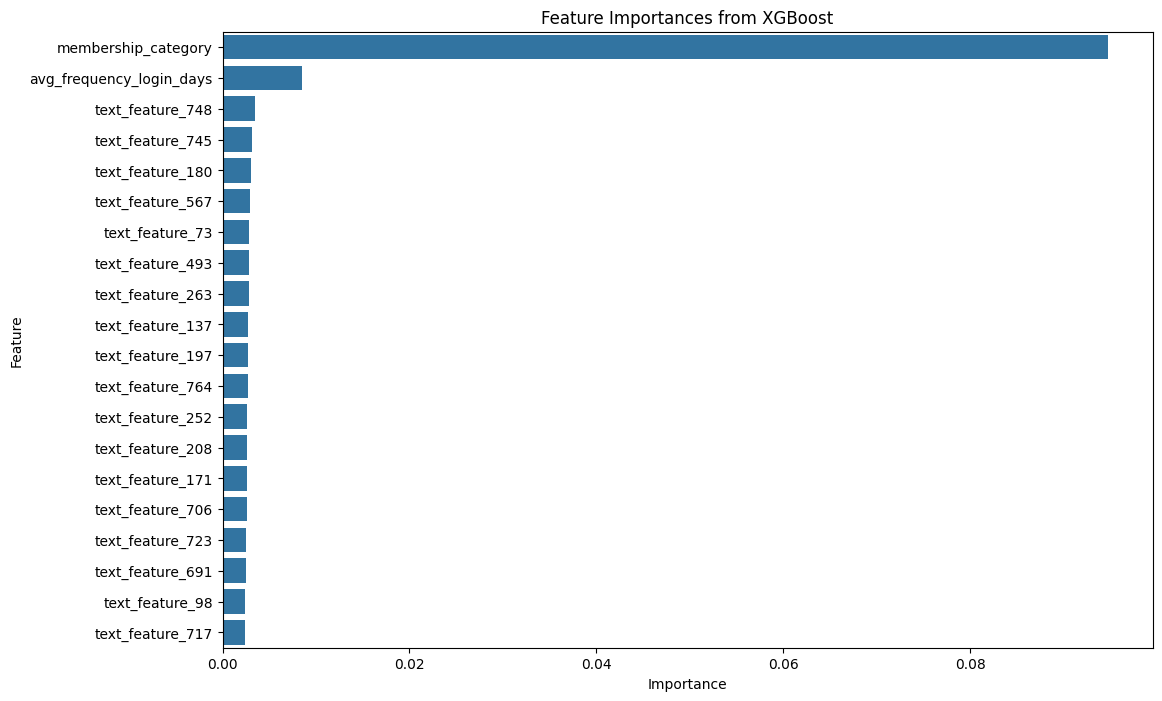

In [80]:
# Getting feature importances
importances = xgb_model.feature_importances_
feature_names = X_train_vectorized.columns

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sorting the DataFrame based on importance and get the top 20 feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:20]

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


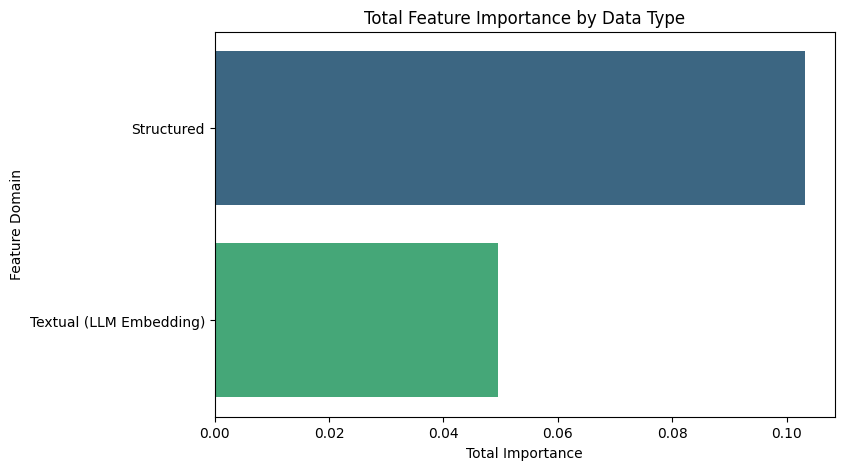

In [81]:
# Add a column to identify domain
def classify_feature_domain(feature_name):
    if feature_name.startswith("text_feature_"):
        return "Textual (LLM Embedding)"
    else:
        return "Structured"

feature_importance_df['Domain'] = feature_importance_df['Feature'].apply(classify_feature_domain)

# Group and sum importances by domain
domain_importance_df = (
    feature_importance_df
    .groupby('Domain')['Importance']
    .sum()
    .reset_index()
    .sort_values(by='Importance', ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Domain', data=domain_importance_df, palette='viridis')
plt.title('Total Feature Importance by Data Type')
plt.xlabel('Total Importance')
plt.ylabel('Feature Domain')
plt.show()

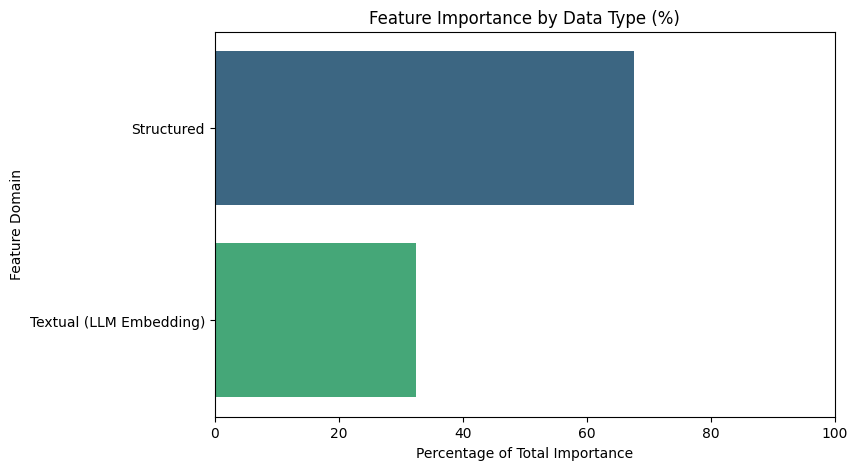

In [82]:
# Add a column to identify domain
def classify_feature_domain(feature_name):
    if feature_name.startswith("text_feature_"):
        return "Textual (LLM Embedding)"
    else:
        return "Structured"

feature_importance_df['Domain'] = feature_importance_df['Feature'].apply(classify_feature_domain)

# Group and sum importances by domain
domain_importance_df = (
    feature_importance_df
    .groupby('Domain')['Importance']
    .sum()
    .reset_index()
)

# Convert to percentage
domain_importance_df['Importance (%)'] = (domain_importance_df['Importance'] / domain_importance_df['Importance'].sum() * 100).round(2)

# Sort for plotting
domain_importance_df = domain_importance_df.sort_values(by='Importance (%)', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance (%)', y='Domain', data=domain_importance_df, palette='viridis')
plt.title('Feature Importance by Data Type (%)')
plt.xlabel('Percentage of Total Importance')
plt.ylabel('Feature Domain')
plt.xlim(0, 100)
plt.show()
